****
# Excess Workshop Data Visualization
****

*Please forward correspondence regarding this notebook and repository to: felix.wagner@oeaw.ac.at, margarita.kaznacheeva@tum.de*

In this notebook, we visualize data that was provided by a set of rare event search collaborations for the EXCESS workshop.


## Introduction

Multiple rare event search experiments observe an exponentially rising count rate at low energies. This phenomenon is yet unexplained and the comparision, description and discussion of the experimental observations is the objective of the EXCESS workshop (https://indico.cern.ch/event/1013203/). The following collaborations have provided data for the workshop and/or are represented within the advisory board (alphabetical list):  

CONNIE/Skipper-CCD  
CRESST  
DAMIC  
EDELWEISS  
MINER  
NEWS-G  
NUCLEUS  
PhyStat-DM  
RICOCHET  
SENSEI  
SuperCDMS  

For futher information, please find the workshops presentations attached to the time table.

In this notebook, we will import the provided data and plot an interactive histogram. For this, we use only standard Python 3 libraries. In case you have not installed all libraries or run this notebook in Docker, the following cell will do the installation.

In [ ]:
!pip install numpy matplotlib ipywidgets

Now we import all libraries and with that are ready for the the data import.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import interact
%config InlineBackend.figure_formats = ['svg']  # this is needed for the plots in a jupyter notebook

## Import Data

First we need to define the paths to the data and the names of the experiments. All four lists (path, path for the efficiency curve, path for the exposure and a name) have to have the same length. The order of the experiments has to be the same in all four lists. There are individual lists for the experiments with unbinned and binned data.

The unbinned data files are *.txt files containing unbinned energy values in keV, seperated by linebreaks.

The binned data files are *.txt files containing binned energy values in keV, seperated by linebreaks:

    first_energy_left_bin_edge       first_energy_right_bin_edge       counts_in_first_bin
    second_energy_left_bin_edge      second_energy_right_bin_edge      counts_in_second_bin
    ...

The efficiency files are *.txt files with the binned, energy dependent survival probability values in the format:

    first_energy_bin_center       first_survival_probability
    second_energy_bin_center      second_survival_probability
    ...

The exposure files can have one of two formats: They can either contain just one value, in case the exposure is energy-independent. Otherwise, they can have the same binned format as the efficiency files:

    first_energy_bin_center       exposure
    second_energy_bin_center      exposure
    ...
    
In case you use a binned, energy-dependent expose, the data files also have to be binned, with the same bin edges.

In [3]:
paths_data_unbinned = [
    'data/converted_data/CRESST/CRESST.txt',
    'data/converted_data/Nucleus/Nucleus_all.txt',
    'data/converted_data/DAMIC/DAMIC.txt',
    'data/converted_data/SuperCDMS/CPD/CPD.txt',
]
paths_efficiencies_unbinned = [
    'data/converted_data/CRESST/CRESST_eff.txt',
    'data/converted_data/Nucleus/Nucleus_all_eff.txt',
    'data/converted_data/DAMIC/DAMIC_eff.txt',
    'data/converted_data/SuperCDMS/CPD/CPD_eff.txt',
]
paths_exposures_unbinned = [
    'data/converted_data/CRESST/CRESST_exposure.txt',
    'data/converted_data/Nucleus/Nucleus_all_exposure.txt',
    'data/converted_data/DAMIC/DAMIC_exposure.txt',
    'data/converted_data/SuperCDMS/CPD/CPD_exposure.txt',
]
names_unbinned = [
    'CRESST-III',
    'Nucleus',
    'DAMIC',
    'SuperCDMS-CPD',
]

paths_data_binned = [
    'data/converted_data/Edelweiss/RED20.txt',
    'data/converted_data/Edelweiss/RED30.txt',
    'data/converted_data/SENSEI/SENSEI.txt',
]
paths_efficiencies_binned = [
    'data/converted_data/Edelweiss/RED20_eff.txt',
    'data/converted_data/Edelweiss/RED30_eff.txt',
    'data/converted_data/SENSEI/SENSEI_eff.txt',
]
paths_exposures_binned = [
    'data/converted_data/Edelweiss/RED20_exposure.txt',
    'data/converted_data/Edelweiss/RED30_exposure.txt',
    'data/converted_data/SENSEI/SENSEI_exposure.txt',
]
names_binned = [
    'Edelweiss-RED20',
    'Edelweiss-RED30',
    'SENSEI',
]

assert len(paths_data_unbinned) == len(paths_efficiencies_unbinned) == len(paths_exposures_unbinned) == len(names_unbinned), "Please put for each data path a corresponding efficiency and exposure path and name of the experiment (unbinned data)!"
assert len(paths_data_binned) == len(paths_efficiencies_binned) == len(paths_exposures_binned) == len(names_binned), "Please put for each data path a corresponding efficiency and exposure path and name of the experiment (binned data)!"

The following cell imports the energy values, efficiency curves and exposures.

In [4]:
data = {n: np.loadtxt(p) for n, p in zip(names_unbinned, paths_data_unbinned)}
efficiencies = {n: np.loadtxt(p) for n, p in zip(names_unbinned, paths_efficiencies_unbinned)}
exposures = {n: np.loadtxt(p) for n, p in zip(names_unbinned, paths_exposures_unbinned)}

for n, p, eff, exp in zip(names_binned, paths_data_binned, paths_efficiencies_binned, paths_exposures_binned):
    data[n] = np.loadtxt(p)
    efficiencies[n] = np.loadtxt(eff)
    exposures[n] = np.loadtxt(exp)
    if len(exposures[n].shape) > 0:
        exposures[n] = exposures[n][:,1]

With the data imported, we can proceed with the plot.

## Interactive Histogram

For comparing the signals, we use an interactive histogram. We need to define the interactive control widgets for the plotting function first. Default values, ranges and options can be adapted in the kwargs dictionary below, if needed.

In [9]:
style = {'description_width': 'initial'}

kwargs = {'bins': widgets.IntSlider(value=100,min=50,max=500, style=style),
          'x_range': widgets.FloatRangeSlider(value=[0,1],min=0,max=200, style=style),
          'y_max': widgets.FloatLogSlider(value=10,min=4,max=11, style=style),
          'auto_y': widgets.Checkbox(value=True, description='Automatic y-axis scaling', style=style),
          'scale_drop': widgets.Dropdown(options=['linear', 'log'], value='log', description='Scale: ', style=style),
          'check_eff': widgets.Checkbox(value=True, description='Correct Efficiency', style=style),
          'grid': widgets.Checkbox(value=True, description='Grid', style=style),
          'figsize': widgets.FloatSlider(value=5,min=1.5,max=8, style=style),
          'fontsize': widgets.FloatSlider(value=14,min=7,max=22, style=style),
          'linew': widgets.FloatSlider(value=2,min=1,max=3, style=style),
          'alpha': widgets.FloatSlider(value=1,min=0,max=1, style=style),
         }
for name in names_unbinned:
    kwargs['check_' + name] = widgets.Checkbox(value=True, description='Plot ' + name, style=style)
    kwargs['shift_' + name] = widgets.FloatSlider(value=0,min=-20,max=20, style=style)
    kwargs['scale_' + name] = widgets.FloatLogSlider(value=1,min=-10,max=10, style=style)
    kwargs['offset_' + name] = widgets.FloatSlider(value=0,min=-1000,max=1000, style=style)
for name in names_binned:
    kwargs['check_' + name] = widgets.Checkbox(value=True, description='Plot ' + name, style=style)
    kwargs['shift_' + name] = widgets.IntSlider(value=0,min=-200,max=200, style=style)
    kwargs['scale_' + name] = widgets.FloatLogSlider(value=1,min=-10,max=10, style=style)
    kwargs['offset_' + name] = widgets.FloatLogSlider(value=0,min=-4,max=4, style=style)
    
kwargs_static = {key: kwargs[key].value for key in list(kwargs.keys())}

The energy spectra of all measurements are plotted into a common histogram, the plot function is defined here. 

In [10]:
def plot_energy_spectra(bins=100, 
             x_range=(0,1), 
             y_max=10e10, 
             auto_y=True,
             scale_drop='linear',
             check_eff=True,
             grid=True,
             figsize=5,
             fontsize=14,
             linew=1.5,
             alpha=1,
             **kwargs,
            ):
    
    x_size = figsize*16/9
    y_size = figsize
    
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['figure.figsize'] = (x_size, y_size)
    mpl.rcParams['axes.titlesize'] = fontsize
    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['lines.linewidth'] = linew
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['mathtext.fontset'] = 'stix'
    mpl.rcParams['font.family'] = 'STIXGeneral'
    
    bin_width = (x_range[1] - x_range[0])/bins 
    print('Bin width: {} eV'.format(bin_width*1000))

    for i, n in enumerate(names_unbinned):
        if kwargs['check_' + n]:
            energy_data = data[n] + kwargs['shift_' + n]
            counts, bin_edges = np.histogram(energy_data, bins, range=x_range)
            if check_eff:
                eff = np.interp(bin_edges[:-1], efficiencies[n][:,0], efficiencies[n][:,1])
                counts = counts / eff
                counts[eff < 1e-4] = 0
            weights = kwargs['scale_' + n]*counts/exposures[n] + kwargs['offset_' + n]
            weights[weights < 0] = 0
            weights = weights / bin_width  # convert to keV kg days
            plt.hist(bin_edges[:-1], bin_edges, weights=weights, histtype='step', label=n, color='C'+str(i), linewidth=linew, alpha=alpha)

    for i, n in enumerate(names_binned):
        if kwargs['check_' + n]:
            counts = data[n][:, 2]
            bin_edges = np.concatenate((data[n][:, 0], [data[n][-1, 1]]))
            counts = np.pad(counts, (0, np.abs(kwargs['shift_' + n])), 'constant', constant_values=(0, 0))
            counts = np.roll(counts, kwargs['shift_' + n])
            counts = counts[:len(bin_edges) - 1]
            if check_eff:
                eff = np.interp(bin_edges[:-1], efficiencies[n][:,0], efficiencies[n][:,1])
                counts = counts / eff
                counts[eff < 1e-4] = 0
            weights = kwargs['scale_' + n]*counts/exposures[n] + kwargs['offset_' + n]
            weights[weights < 0] = 0
            plt.hist(bin_edges[:-1], bin_edges, weights=weights, histtype='step', label=n, color='C'+str(i + len(names_unbinned)), linewidth=linew, alpha=alpha)
            
    if grid:
        plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.xlabel('Energy (keV)')
    plt.ylabel(f'Counts / (keV kg days)')
    plt.legend(bbox_to_anchor=(1, 0.7))
    plt.xlim(x_range)
    if not auto_y:
        plt.ylim((0.5, y_max))
    plt.yscale(scale_drop)
    plt.show()

For comparing the data in a meaningful way, we list here which experiments measure total energy and which measure electron equivalents. 

    CRESST-III: Total energy deposition.   
    Nucleus: Total energy deposition.  
    DAMIC: Electron equivalent energy.  
    SuperCDMS-CPD: Total energy deposition.  
    Edelweiss-RED20: Total energy deposition.  
    Edelweiss-RED30: Total energy deposition, converted from electron equivalent.  
    SENSEI: Electron equivalent energy, converted from electron-hole pairs.    

We start now with a static plot of the low energy excess region, which can be seen on GitHub directly. 

Bin width: 10.0 eV


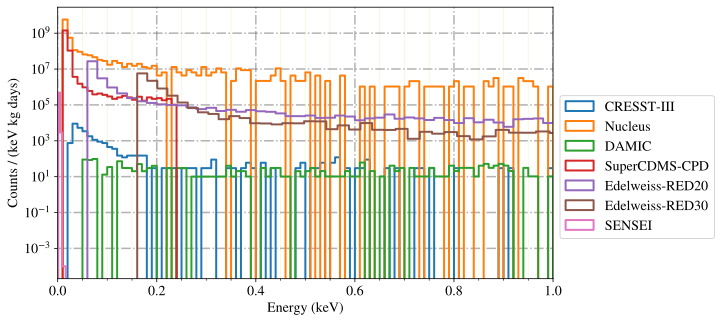

In [11]:
plot_energy_spectra(**kwargs_static)

For better visibility, we also do an interactive plot. Adaptable parameters of the plot are the number of bins, the energy range, the scaling, the efficiency correction, as well as the figure and font size, linewidth and grid. The signal of each experiment can be scaled, shifted and offset w.r.t. the other signals, to account for different backgrounds and shieldings.

In [12]:
_ = interact(plot_energy_spectra, **kwargs)

interactive(children=(IntSlider(value=100, description='bins', max=500, min=50, style=SliderStyle(description_…

## Open Data Access

In the GitHub data repository of the EXCESS workshop (github.com/fewagner/excess), the folder `data/` contains all data provided by the collaborations. The original data is in the directories `data/original_data/<EXPERIMENT_NAME>/`, while a preprocessed and uniformly formatted version is in the directories `data/converted_data/<EXPERIMENT_NAME>`.

The data is subject to the CC BY 4.0 license (https://creativecommons.org/licenses/by/4.0/). If you want to use the here available data in your own work, please reference the corresponding or a suitable publication of the data providing collaboration, as they are listed in the references of this notebook.

This notebook and the code contained in the GitHub repository is subject to the MIT license (https://choosealicense.com/licenses/mit/). If you want to reference the EXCESS workshop or this notebook and repository explicitely, please cite: 

    @misc{excess_workshop_2021,
        author       = {EXCESS Workshop},
        title        = {{Data Repository}},
        month        = june,
        year         = 2021,
        url          = {https://github.com/fewagner/excess}
        urldate = {2021-06-16}
        }

## References

TODO: add one reference to each collaboration or a paper